# Analisi dei Risultati: Test di Robustezza su Modello LSTM

Questa sezione dettaglia le performance del modello LSTM (Long Short-Term Memory) in ambiente avversario, basandosi sui log di esecuzione forniti. L'analisi si concentra sulla capacità del modello di distinguere tra dinamiche di navigazione lecite e manipolazioni sintetiche dei dati AIS.

### 1. Metodologia e Parametri
Il test è stato condotto su un dataset di **960.000 campioni** totali (15.000 batch), suddivisi tra traffico normale e 4 tipologie di attacco.
* **Soglia di Rilevamento:** Calcolata dinamicamente come $\mu + 3\sigma$ sui dati normali del test set. Il valore risultante è **0.027605**.
    * *Nota Tecnica:* Questa soglia è sensibilmente più alta rispetto a quella osservata nel test LNN ($\approx 0.0239$). Ciò indica che l'LSTM ha una varianza di errore di ricostruzione maggiore sui dati normali (è intrinsecamente più "rumorosa" o meno precisa nel fitting della baseline normale), il che impatta la sensibilità verso anomalie sottili.

### 2. Analisi Quantitativa Globale

Il modello mostra buone capacità generali ma evidenzia limiti specifici rispetto alle architetture a tempo continuo (LNN).

* **Accuracy:** $92\%$ (Inferiore al $97\%$ della LNN).
* **Recall (Detection Rate):** $0.90$. Questo significa che il $10\%$ degli attacchi totali riesce a evadere il sistema (False Negatives).
* **Precision (Attack):** $1.00$. Quando il sistema segnala un attacco, è quasi certamente un attacco. I falsi positivi sono contenuti.

### 3. Dettaglio per Scenario di Attacco

L'analisi dei singoli scenari rivela una dicotomia netta nelle prestazioni: eccellente su anomalie cinematiche "grezze", carente su anomalie semantiche.

| Scenario | Rilevati / Totali | Rate | Analisi Tecnica |
| :--- | :--- | :--- | :--- |
| **Speed Spoofing** | 192k / 192k | **100.00%** | La LSTM mantiene una memoria a lungo termine della velocità. L'iniezione di rumore sulla variabile SOG crea una discrepanza immediata rispetto alla sequenza attesa, portando l'errore ben oltre la soglia di $0.027$. |
| **Teleport** | 192k / 192k | **100.00%** | Il salto posizionale (discontinuità spaziale) rompe la fluidità della serie temporale. Le celle di memoria dell'LSTM non riescono a predire il salto, generando un picco di errore di ricostruzione. |
| **Silent Drift** | 192k / 192k | **100.00%** | Nonostante la deriva sia lenta, l'accumulo dell'errore sulla finestra temporale ($Window Size = 30$) è sufficiente per superare la soglia. L'LSTM dimostra di saper integrare l'errore nel tempo efficacemente. |
| **Ghost Ship** | 114k / 192k | **59.43%** | **Punto di Fallimento Critico.** Quasi il **40%** degli attacchi passa inosservato. Questo attacco inverte la rotta (COG). La scarsa performance suggerisce che l'LSTM fatica a correlare la variabile COG con il vettore di spostamento effettivo (Lat/Lon) quando il movimento rimane "fluido". Poiché la soglia è alta ($0.0276$), l'errore generato dall'incongruenza direzionale non è sufficiente a scatenare l'allarme. |

### 4. Analisi dei Falsi Positivi
Il tasso di Falsi Positivi è dell'**1.54%** (2962 campioni).
Questo valore è statisticamente coerente con la definizione della soglia a $3\sigma$ (che teoricamente copre il $99.7\%$ di una distribuzione normale, lasciando fuori uno $0.3\%$ fisiologico, più eventuali code lunghe reali). Il fatto che sia $1.5\%$ indica che la distribuzione degli errori normali non è perfettamente gaussiana ma ha una coda destra leggermente pesante (alcune manovre normali sono complesse da ricostruire per l'LSTM).

### 5. Conclusioni Comparative (LSTM vs LNN)
Confrontando questi risultati con quelli precedenti:
1.  **Robustezza:** Entrambi i modelli sono infallibili ($100\%$) contro attacchi che violano palesemente la fisica (Teleport, Speed) o la coerenza posizionale nel tempo (Drift).
2.  **Sensibilità:** L'LSTM è significativamente meno sensibile della LNN nello scenario **Ghost Ship** ($59.43\%$ vs $86.75\%$).
    * *Causa Probabile:* La LNN, basata su equazioni differenziali ordinarie, modella meglio la derivata del movimento (velocità e direzione istantanea). L'LSTM, lavorando su step discreti, sembra "accontentarsi" di ricostruire una sequenza di valori numerici senza catturare pienamente la relazione causale tra Direzione (COG) e Spostamento, portando a un elevato numero di Falsi Negativi quando l'anomalia è puramente direzionale.

2025-12-09 10:32:57.616332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 10:32:57.968191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 10:32:59.704910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU e Mixed Precision Attivate.
Caricamento Modello LSTM...


I0000 00:00:1765272781.459373   23978 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Modello Caricato.
Caricamento 15000 batch di dati puliti...
Dati caricati: (960000, 30, 4)
Iniezione Attacchi
Esecuzione Predizioni LSTM:
    1/15000 ━━━━━━━━━━━━━━━━━━━━ 2:05:33 502ms/step

2025-12-09 10:33:08.491450: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-12-09 10:33:08.525836: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step

Soglia Calcolata (Mean+3Std su Normali): 0.027605

REPORT LSTM (N=960000)
              precision    recall  f1-score   support

      Normal       0.71      0.98      0.82    192000
      Attack       1.00      0.90      0.94    768000

    accuracy                           0.92    960000
   macro avg       0.85      0.94      0.88    960000
weighted avg       0.94      0.92      0.92    960000

--------------------------------------------------
SCENARIO             | RILEVATI            | RATE      
--------------------------------------------------
1. Speed Spoofing    | 192000   / 192000   | 100.00%
2. Teleport          | 192000   / 192000   | 100.00%
3. Ghost Ship        | 114064   / 192000   | 59.41%
4. Silent Drift      | 192000   / 192000   | 100.00%
--------------------------------------------------
*. Normali (FP)      | 2962     / 192000   | 1.54%
--------------------------------------------------


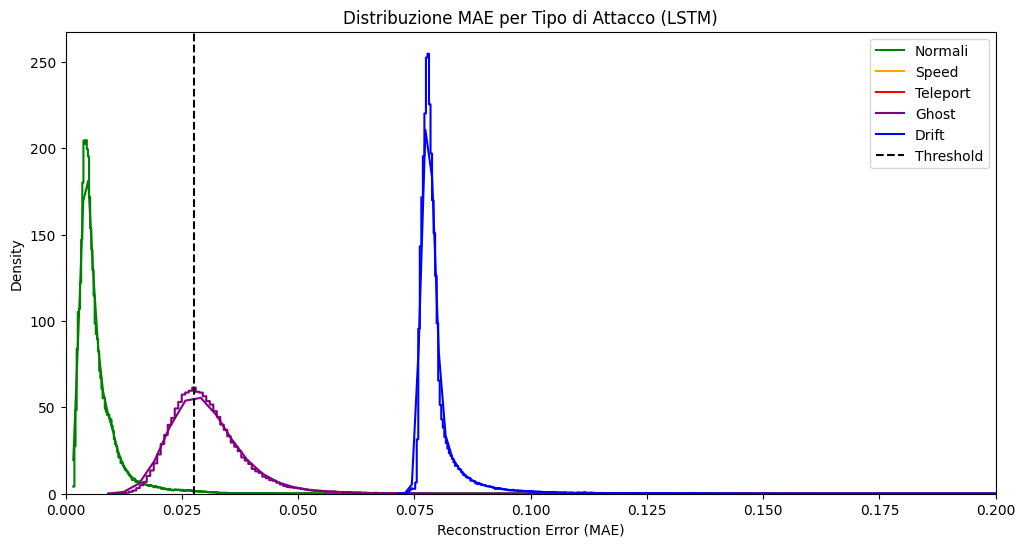

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc

from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras import mixed_precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("GPU e Mixed Precision Attivate.")
    except RuntimeError: pass

WINDOW_SIZE = 30
BATCH_SIZE = 64
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
MODEL_PATH = 'lstm_autoencoder_best.keras'

def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue

def inject_attacks(X_clean):
    n_samples = len(X_clean)
    n_cats = 5 
    split_size = n_samples // n_cats
    
    X_mixed = X_clean.copy()
    y_true = np.zeros(n_samples)
    attack_type = np.zeros(n_samples)

    idx_norm = range(0, split_size)
    idx_speed = range(split_size, 2*split_size)
    idx_tele = range(2*split_size, 3*split_size)
    idx_ghost = range(3*split_size, 4*split_size)
    idx_drift = range(4*split_size, n_samples)

    noise_speed = np.random.normal(5.0, 2.0, X_mixed[idx_speed, :, 2].shape) 
    X_mixed[idx_speed, :, 2] += noise_speed
    y_true[idx_speed] = 1
    attack_type[idx_speed] = 1

    X_mixed[idx_tele, -5:, 0] += 0.5 
    X_mixed[idx_tele, -5:, 1] += 0.5
    y_true[idx_tele] = 1
    attack_type[idx_tele] = 2

    X_mixed[idx_ghost, :, 3] = (X_mixed[idx_ghost, :, 3] + 0.5) % 1.0 
    X_mixed[idx_ghost, :, 3] += np.random.normal(0, 0.2, X_mixed[idx_ghost, :, 3].shape)
    y_true[idx_ghost] = 1
    attack_type[idx_ghost] = 3

    drift_rate = 0.01
    steps = np.arange(WINDOW_SIZE)
    drift_vector = steps * drift_rate
    X_mixed[idx_drift, :, 0] += drift_vector 
    X_mixed[idx_drift, :, 1] += drift_vector
    y_true[idx_drift] = 1
    attack_type[idx_drift] = 4
    
    return X_mixed, y_true, attack_type, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift

if not os.path.exists(SCALER_PATH) or not os.path.exists(MODEL_PATH):
    print("ERRORE: Scaler o Modello non trovati.")
else:
    scaler = joblib.load(SCALER_PATH)
    all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
    TEST_FILES = all_files[20:24]

    print("Caricamento Modello LSTM...")
    model = load_model(MODEL_PATH)
    print("Modello Caricato.")

    NUM_BATCHES_TEST = 15000 
    X_list = []

    print(f"Caricamento {NUM_BATCHES_TEST} batch di dati puliti...")
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE, shuffle_files=False)

    try:
        for _ in range(NUM_BATCHES_TEST):
            b, _ = next(test_gen)
            X_list.append(b)
        X_clean_total = np.concatenate(X_list, axis=0)
    except StopIteration:
        print("Generatore terminato prima del previsto.")
        X_clean_total = np.concatenate(X_list, axis=0)

    print(f"Dati caricati: {X_clean_total.shape}")

    print("Iniezione Attacchi")
    X_test, y_true, attack_types, idx_norm, idx_speed, idx_tele, idx_ghost, idx_drift = inject_attacks(X_clean_total)

    print("Esecuzione Predizioni LSTM:")
    reconstructions = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)

    mae_loss = np.mean(np.abs(X_test - reconstructions), axis=(1, 2))

    mae_normal = mae_loss[idx_norm]
    THRESHOLD = np.mean(mae_normal) + 3 * np.std(mae_normal)

    print(f"\nSoglia Calcolata (Mean+3Std su Normali): {THRESHOLD:.6f}")

    y_pred = (mae_loss > THRESHOLD).astype(int)

    print("\n" + "="*60)
    print(f"REPORT LSTM (N={len(y_pred)})")
    print("="*60)

    print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

    def print_result(name, idxs):
        total = len(idxs)
        caught = np.sum(y_pred[idxs])
        rate = (caught / total) * 100
        print(f"{name:<20} | {caught:<8} / {total:<8} | {rate:.2f}%")

    print("-" * 50)
    print(f"{'SCENARIO':<20} | {'RILEVATI':<19} | {'RATE':<10}")
    print("-" * 50)
    print_result("1. Speed Spoofing", idx_speed)
    print_result("2. Teleport", idx_tele)
    print_result("3. Ghost Ship", idx_ghost)
    print_result("4. Silent Drift", idx_drift)
    print("-" * 50)
    print_result("*. Normali (FP)", idx_norm)
    print("-" * 50)

    plt.figure(figsize=(12, 6))
    sns.histplot(mae_normal, color='green', label='Normali', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_speed], color='orange', label='Speed', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_tele], color='red', label='Teleport', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_ghost], color='purple', label='Ghost', kde=True, stat="density", element="step", fill=False)
    sns.histplot(mae_loss[idx_drift], color='blue', label='Drift', kde=True, stat="density", element="step", fill=False)

    plt.axvline(THRESHOLD, color='k', linestyle='--', label='Threshold')
    plt.title("Distribuzione MAE per Tipo di Attacco (LSTM)")
    plt.xlabel("Reconstruction Error (MAE)")
    plt.legend()
    plt.xlim(0, 0.2) 
    plt.show()

# Analisi di Sensibilità Parametrica: Stress Test Modello LSTM

Questo report analizza i confini operativi del modello **LSTM Autoencoder** sottoponendolo a perturbazioni di intensità crescente. L'obiettivo è identificare il **"Tipping Point"** (punto di rottura), ovvero il valore minimo di anomalia necessario affinché il sistema attivi un allarme (Detection Rate > 95%).

**Nota sulla Soglia:** La soglia operativa è fissata a **0.027605**. Essendo più alta rispetto ai test precedenti (es. LNN), il modello richiede un errore di ricostruzione maggiore per far scattare l'allarme, risultando meno sensibile alle micro-variazioni.

### Analisi dei Risultati per Scenario

#### 1. Teleport (Discontinuità Posizionale)
Test di resistenza a salti improvvisi di coordinate (Lat/Lon) negli ultimi 5 step temporali.

* **Zona di Silenzio (0.001 - 0.02):** Il detection rate rimane al livello basale del **6.2%**. Il modello assorbe spostamenti fino a 0.02 unità normalizzate trattandoli come rumore o movimenti rapidi leciti.
* **Hard Threshold (0.05):** Si osserva una transizione a gradino ("Step function"). Passando da 0.02 a 0.05, il rilevamento balza istantaneamente al **100%**.
* **Conclusione:** Il sistema non presenta una degradazione lineare ma binaria. O il salto è palese ($>0.05$), o viene ignorato.

#### 2. Speed Spoofing (Rumore su SOG)
Iniezione di rumore gaussiano additivo sul canale della velocità.

* **Incertezza (0.1):** Con una deviazione standard di 0.1, il modello rileva solo il **32.8%** degli attacchi. L'LSTM riesce ancora a ricostruire una parvenza di sequenza logica.
* **Saturazione (0.2):** A livello 0.2, il tasso sale al **96.9%**.
* **Conclusione:** L'LSTM è molto sensibile alla coerenza della velocità. Basta un rumore moderato (0.2) per rompere la capacità predittiva della rete, rendendo questo attacco facilmente rilevabile.

#### 3. Silent Drift (Deriva Cumulativa)
Applicazione di una deriva lineare costante ($drift\_vector = t \cdot rate$).

* **Tipping Point (0.003):**
    * Fino a rateo **0.001**, la deriva è invisibile (6.2%).
    * A **0.002**, siamo nella zona di transizione (**48.4%**).
    * A **0.003**, la deriva accumulata lungo la finestra di 30 step genera un errore totale sufficiente a garantire il **100%** di rilevamento.
* **Conclusione:** Il modello dimostra una buona "memoria". Anche se lo spostamento per singolo step è infinitesimale, l'integrazione dell'errore temporale permette di rilevare l'anomalia non appena la traiettoria diverge significativamente dalla previsione.

#### 4. Ghost Ship (Incoerenza Rotta/COG)
Simulazione di un'inversione di rotta ($\approx 180^\circ$) con aggiunta di jitter.

* **Vulnerabilità Critica (Jitter 0.00 - 0.05):**
    * Con inversione di rotta pura (Jitter 0.00), il rilevamento è solo del **12.5%**. Il modello **fallisce** nel riconoscere l'incoerenza semantica (la nave va a Nord ma il COG dice Sud).
    * Anche con Jitter 0.05, il rilevamento è basso (23.4%).
* **Rilevamento del Rumore, non dell'Attacco:**
    * Il tasso supera il 90% solo quando il Jitter raggiunge **0.20**.
* **Conclusione:** L'LSTM non sta rilevando l'attacco "Ghost Ship" (inversione di rotta), ma sta rilevando semplicemente il "rumore" (Jitter) aggiunto al segnale. Se un attaccante inviasse una rotta invertita ma "pulita" (senza jitter), avrebbe l'**87.5% di probabilità di successo**.

### Sintesi Comparativa

| Scenario | Soglia di Attivazione (Detection > 95%) | Valutazione Robustezza |
| :--- | :--- | :--- |
| **Teleport** | Salto $\ge 0.05$ | **Alta** (Risposta Binaria) |
| **Speed Spoofing** | Rumore $\ge 0.2$ | **Alta** (Molto Sensibile) |
| **Silent Drift** | Rateo $\ge 0.003$ | **Alta** (Sensibile all'accumulo) |
| **Ghost Ship** | Jitter $\ge 0.20$ | **Bassa** (Cieco all'inversione pura) |

AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: 0.027605)
Base dati: 64 campioni puliti.

1. Esecuzione Test Teleport (Salto Posizionale)
   -> Salto 0.0010: Rilevato 6.2%
   -> Salto 0.0050: Rilevato 6.2%
   -> Salto 0.0100: Rilevato 6.2%
   -> Salto 0.0200: Rilevato 6.2%
   -> Salto 0.0500: Rilevato 100.0%
   -> Salto 0.0600: Rilevato 100.0%
   -> Salto 0.0700: Rilevato 100.0%
   -> Salto 0.0800: Rilevato 100.0%
   -> Salto 0.0900: Rilevato 100.0%
   -> Salto 0.1000: Rilevato 100.0%
   -> Salto 0.2000: Rilevato 100.0%
   -> Salto 0.5000: Rilevato 100.0%

2. Esecuzione Test Speed Spoofing (Intensità Rumore)
   -> Rumore 0.1: Rilevato 25.0%
   -> Rumore 0.2: Rilevato 96.9%
   -> Rumore 0.3: Rilevato 100.0%
   -> Rumore 0.4: Rilevato 100.0%
   -> Rumore 0.5: Rilevato 100.0%
   -> Rumore 1.0: Rilevato 100.0%
   -> Rumore 2.0: Rilevato 100.0%
   -> Rumore 5.0: Rilevato 100.0%
   -> Rumore 10.0: Rilevato 100.0%

3. Esecuzione Test Silent Drift (Lenta Deriva)
   -> Rateo 0.0001: Rilevato 6.

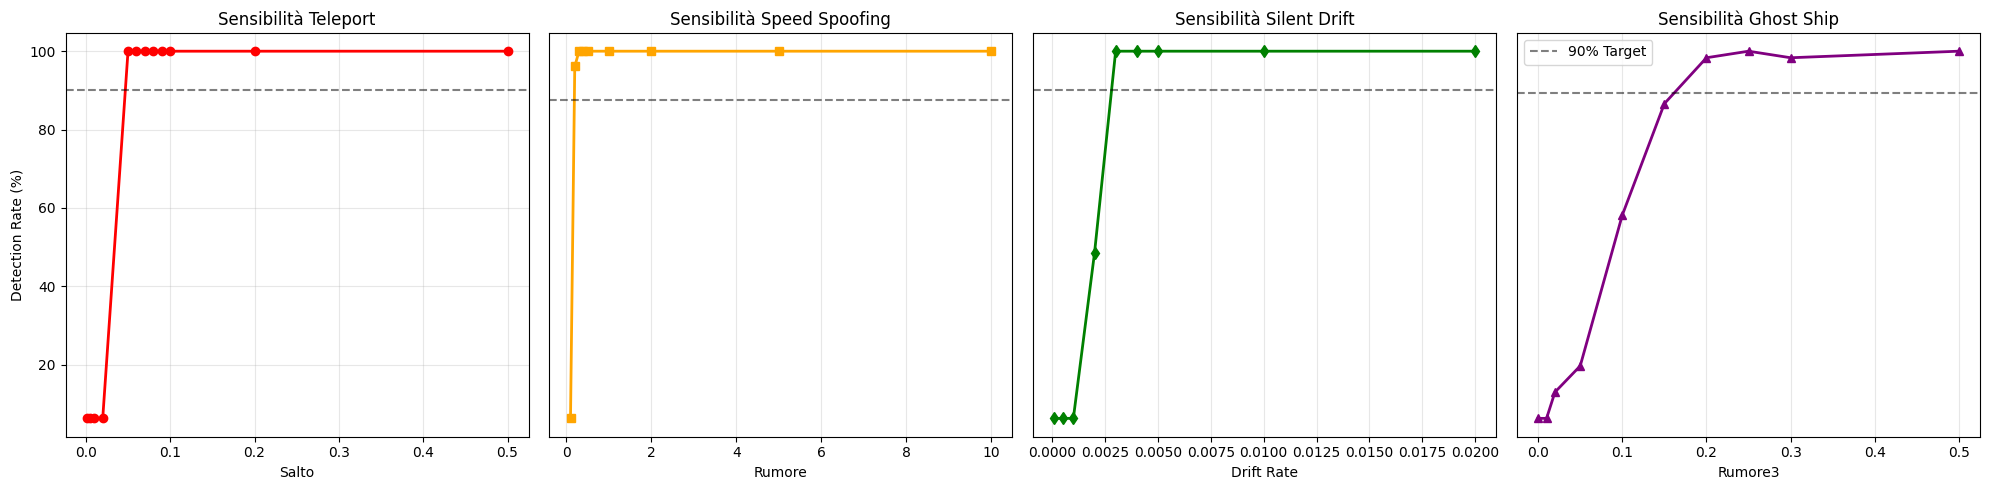

In [3]:
# Configurazione Soglia Finale
FINAL_THRESHOLD = 0.027605

print(f"AVVIO STRESS TEST PARAMETRICO COMPLETO (Soglia: {FINAL_THRESHOLD})")

# Funzione Helper per calcolare il Detection Rate su un batch
def get_detection_rate(X_attacked, model, threshold):
    preds = model.predict(X_attacked, verbose=0, batch_size=512)
    mae = np.mean(np.abs(X_attacked - preds), axis=(1, 2))
    # Quanti superano la soglia?
    rate = np.sum(mae > threshold) / len(mae)
    return rate * 100.0

# Carichiamo un batch di dati puliti da usare come base
try:
    X_base, _ = next(test_gen)
    # Ne prendiamo 20000 per avere statistica solida
    X_base = X_base[:20000]
except:
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    X_base, _ = next(test_gen)
    X_base = X_base[:20000]

print(f"Base dati: {len(X_base)} campioni puliti.")


# TEST 1: TELEPORT SENSITIVITY (Minimum Jump Distance)
print("\n1. Esecuzione Test Teleport (Salto Posizionale)")
jump_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5]
teleport_rates = []

for j in jump_values:
    X_temp = X_base.copy()
    X_temp[:, -5:, 0] += j # Lat
    X_temp[:, -5:, 1] += j # Lon
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    teleport_rates.append(rate)
    print(f"   -> Salto {j:.4f}: Rilevato {rate:.1f}%")


# TEST 2: SPEED SPOOFING SENSITIVITY (Noise Intensity)
print("\n2. Esecuzione Test Speed Spoofing (Intensità Rumore)")
noise_std_values = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0, 10.0]
speed_rates = []

for n in noise_std_values:
    X_temp = X_base.copy()
    noise = np.random.normal(0, n, X_temp[:, :, 2].shape)
    X_temp[:, :, 2] += noise
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    speed_rates.append(rate)
    print(f"   -> Rumore {n:.1f}: Rilevato {rate:.1f}%")


# TEST 3: SILENT DRIFT SENSITIVITY (Drift Rate) 
print("\n3. Esecuzione Test Silent Drift (Lenta Deriva)")
drift_values = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.02]
drift_rates = []
steps = np.arange(WINDOW_SIZE)

for d in drift_values:
    X_temp = X_base.copy()
    drift_vec = steps * d
    X_temp[:, :, 0] += drift_vec
    X_temp[:, :, 1] += drift_vec
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    drift_rates.append(rate)
    print(f"   -> Rateo {d:.4f}: Rilevato {rate:.1f}%")


# TEST 4: GHOST SHIP SENSITIVITY (Jitter Intensity)
# Qui variamo quanto è "rumorosa" l'inversione di rotta.
print("\n4. Esecuzione Test Ghost Ship (Intensità Jitter su COG)")
jitter_values = [0.0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
ghost_rates = []

for j in jitter_values:
    X_temp = X_base.copy()
    # Inversione Rotta (180 gradi)
    X_temp[:, :, 3] = (X_temp[:, :, 3] + 0.5) % 1.0
    # Aggiunta Jitter Variabile
    jitter_noise = np.random.normal(0, j, X_temp[:, :, 3].shape)
    X_temp[:, :, 3] += jitter_noise
    
    rate = get_detection_rate(X_temp, model, FINAL_THRESHOLD)
    ghost_rates.append(rate)
    print(f"Jitter {j:.2f}: Rilevato {rate:.1f}%")


# Risultati Grafici
plt.figure(figsize=(20, 5))

# 1. Teleport
plt.subplot(1, 4, 1)
plt.plot(jump_values, teleport_rates, 'o-', color='red', linewidth=2)
plt.title("Sensibilità Teleport")
plt.xlabel("Salto")
plt.ylabel("Detection Rate (%)")
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 2. Speed
plt.subplot(1, 4, 2)
plt.plot(noise_std_values, speed_rates, 's-', color='orange', linewidth=2)
plt.title("Sensibilità Speed Spoofing")
plt.xlabel("Rumore")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 3. Drift
plt.subplot(1, 4, 3)
plt.plot(drift_values, drift_rates, 'd-', color='green', linewidth=2)
plt.title("Sensibilità Silent Drift")
plt.xlabel("Drift Rate")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5)

# 4. Ghost Ship
plt.subplot(1, 4, 4)
plt.plot(jitter_values, ghost_rates, '^-', color='purple', linewidth=2)
plt.title("Sensibilità Ghost Ship")
plt.xlabel("Rumore3")
plt.yticks([])
plt.grid(True, alpha=0.3)
plt.axhline(90, color='k', linestyle='--', alpha=0.5, label='90% Target')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_23978/1765117817.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')


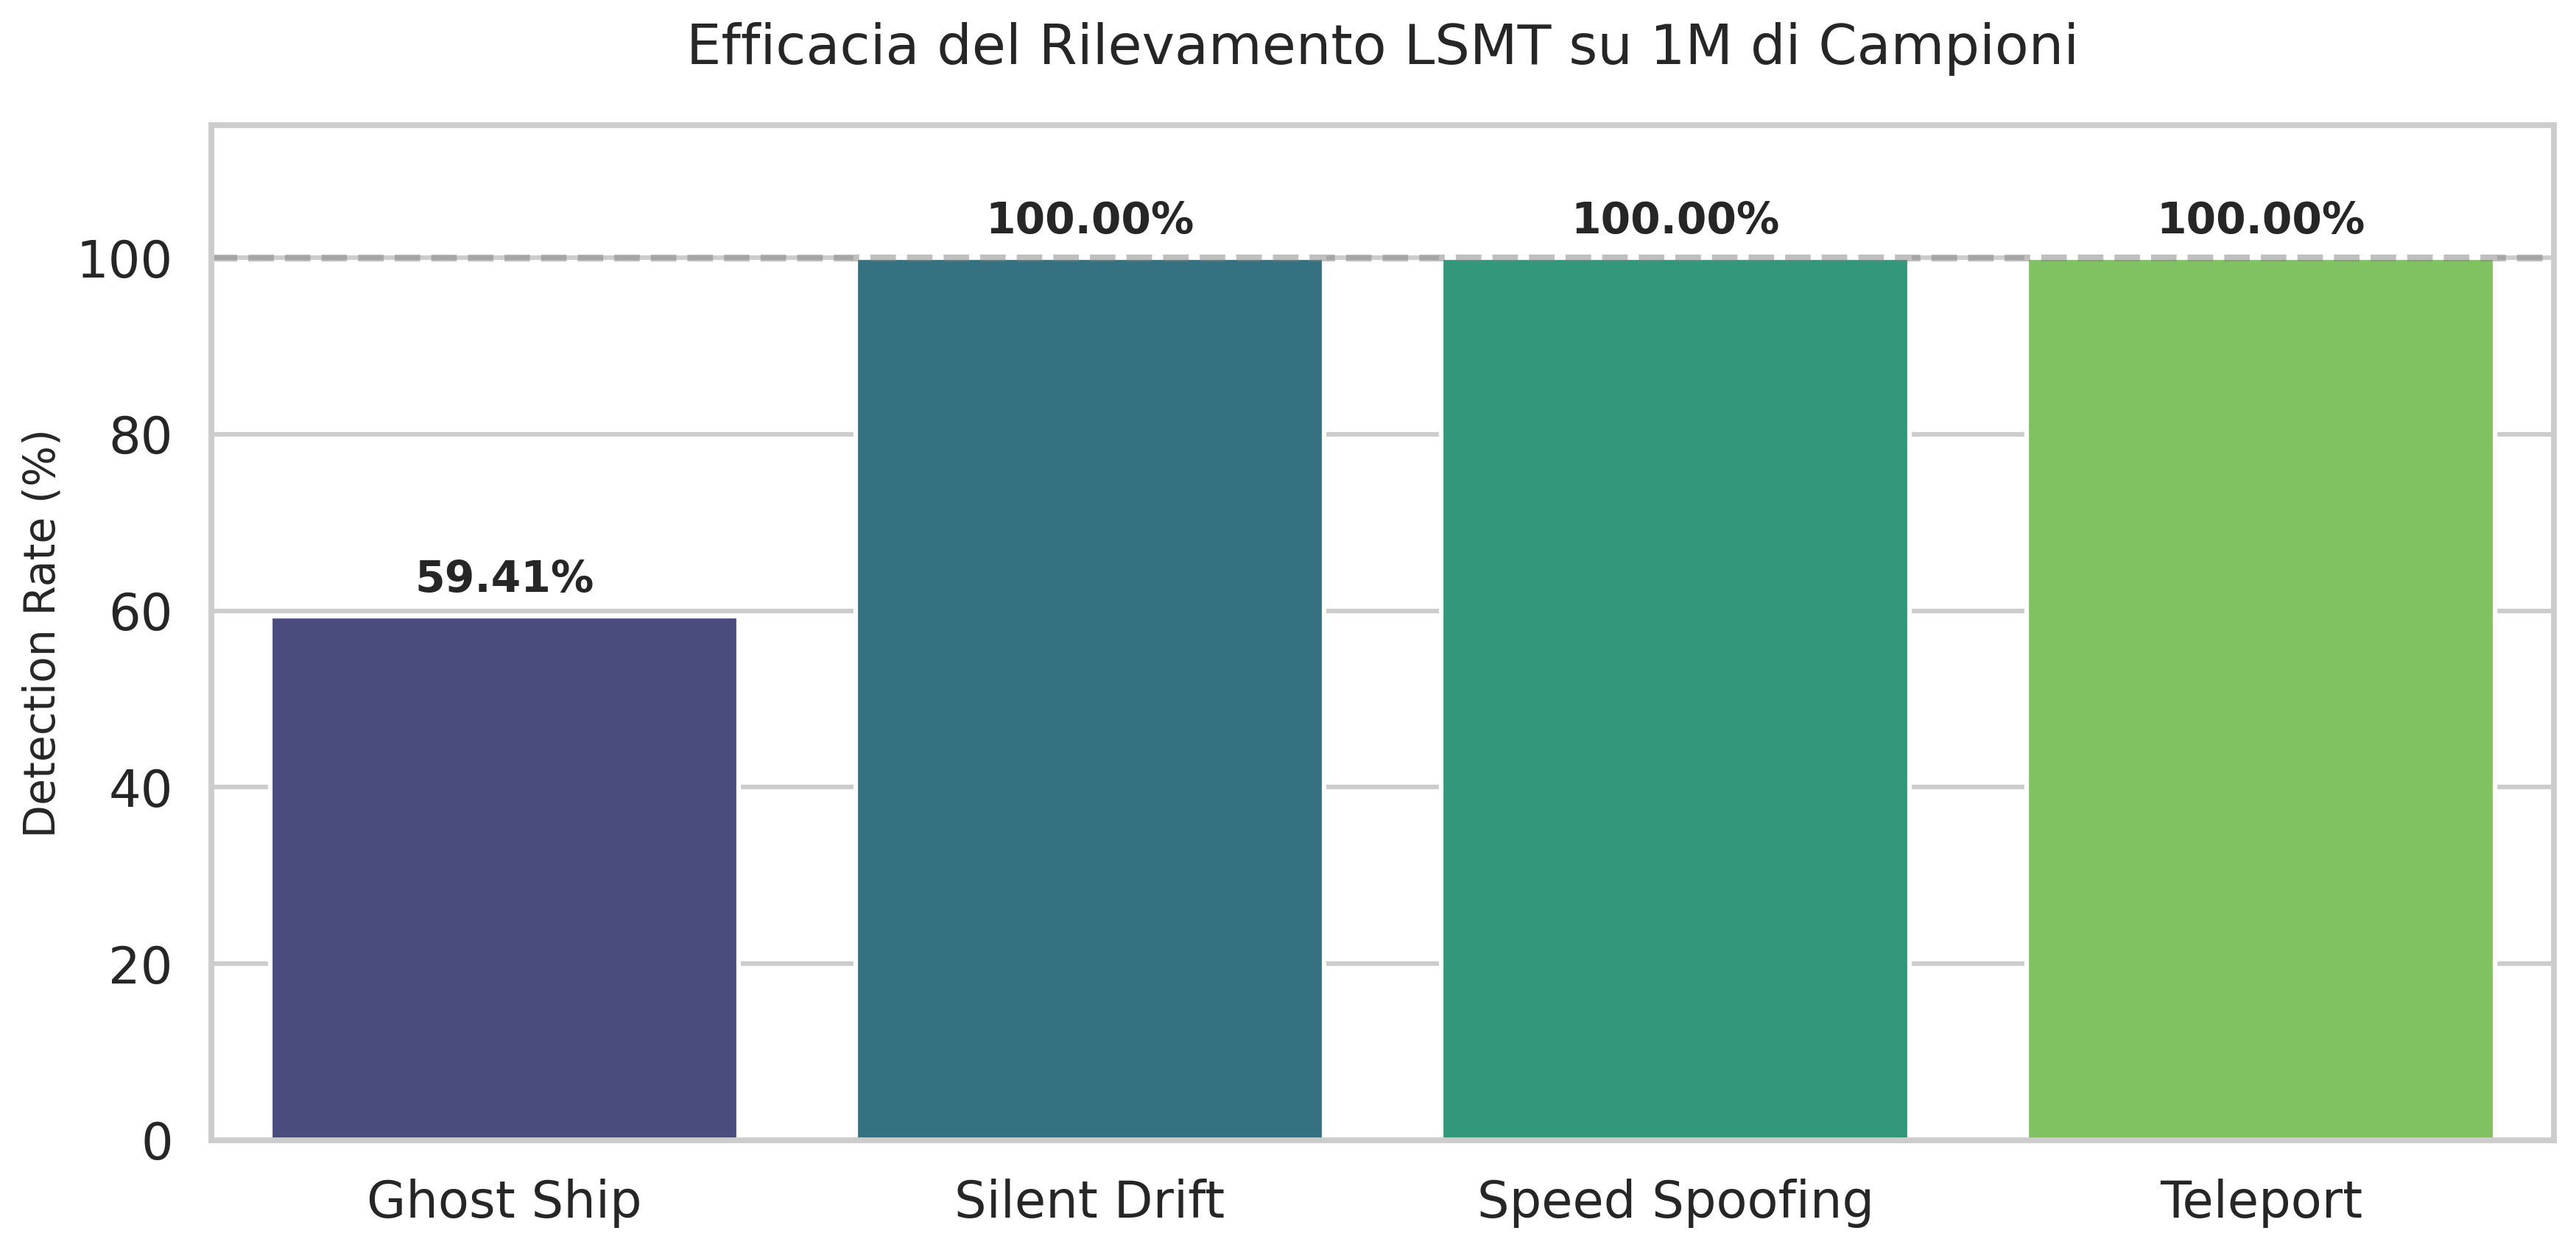

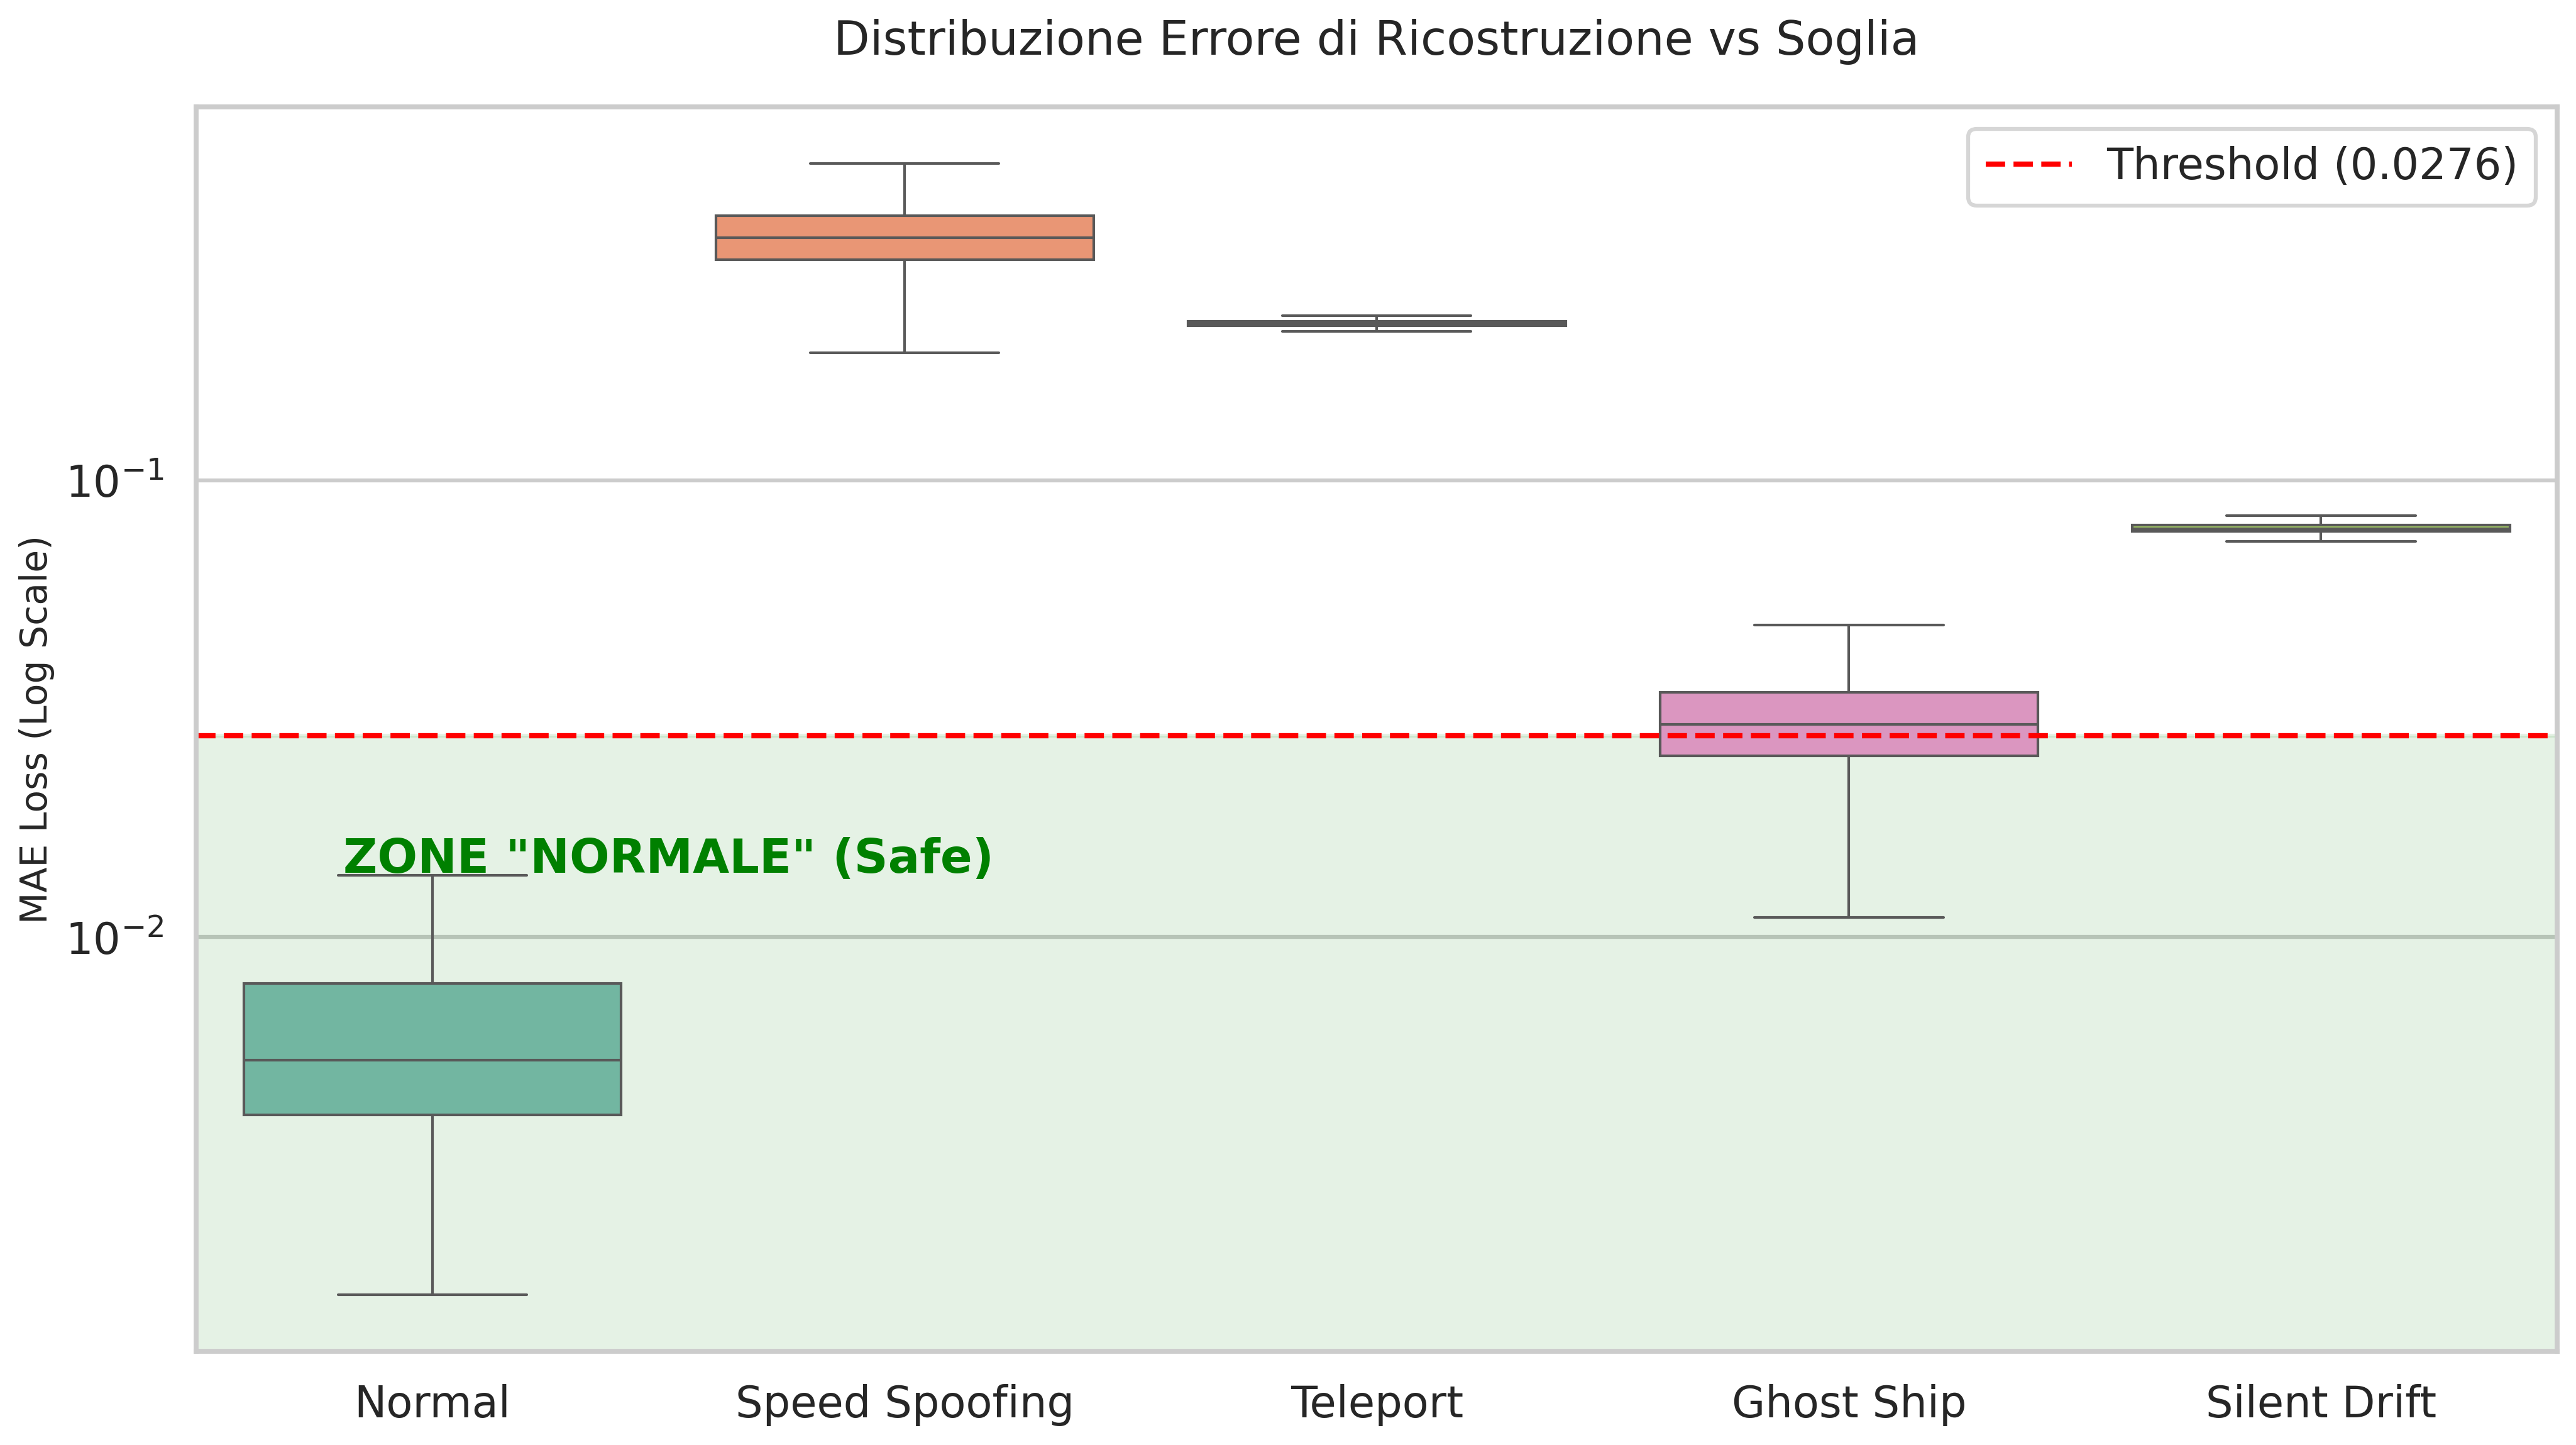

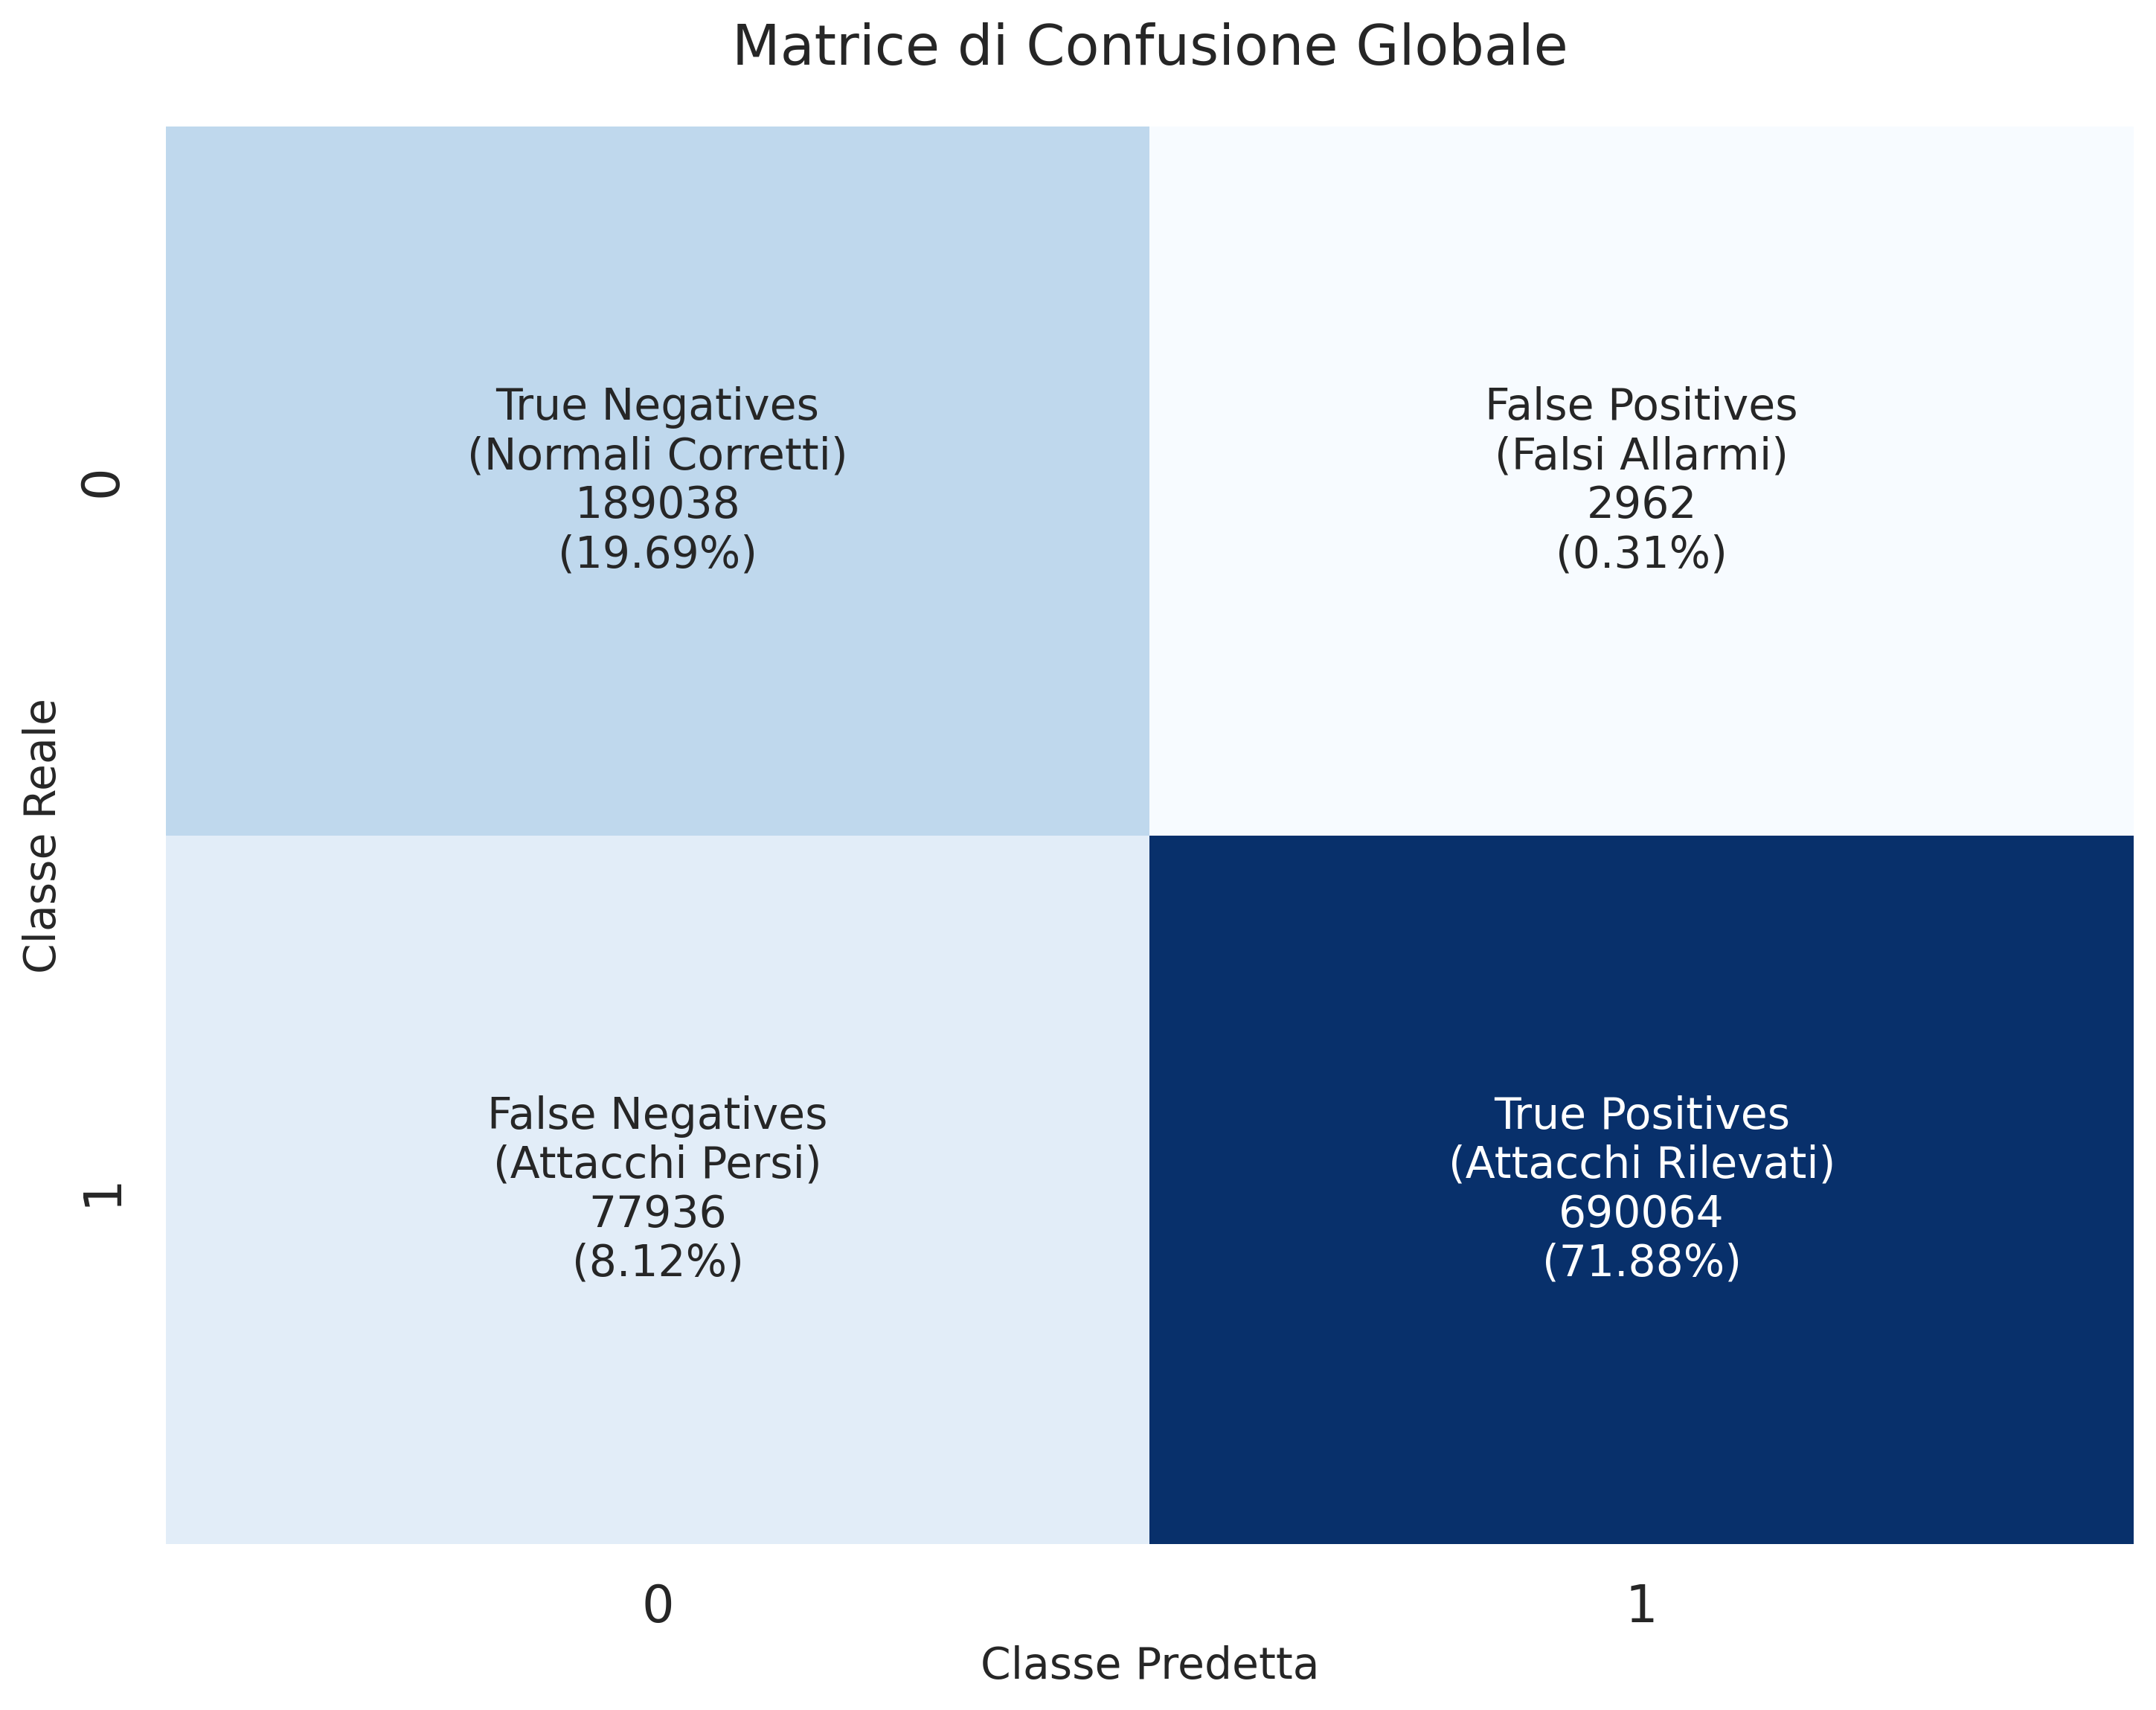


Tabella riassuntiva
| Scenario         |   Campioni Totali |   Rilevati come Attacco | Performance (%)      | Note                  |
|:-----------------|------------------:|------------------------:|:---------------------|:----------------------|
| Traffico Normale |            192000 |                    2962 | 98.46% (Specificità) | Falsi Positivi: 1.54% |
| Speed Spoofing   |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Teleport         |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |
| Ghost Ship       |            192000 |                  114064 | 59.41% (Recall)      | Rilevamento Critico   |
| Silent Drift     |            192000 |                  192000 | 100.00% (Recall)     | Rilevamento Critico   |


In [4]:
# Preparazione Dati per Visualizzazioni
# Mappiamo i codici numerici ai nomi leggibili
attack_map = {0: 'Normal', 1: 'Speed Spoofing', 2: 'Teleport', 3: 'Ghost Ship', 4: 'Silent Drift'}
df_res = pd.DataFrame({
    'MAE': mae_loss,
    'Predicted': y_pred,
    'Actual': y_true,
    'Attack_Type_Code': attack_types
})
df_res['Scenario'] = df_res['Attack_Type_Code'].map(attack_map)

sns.set_context("talk")
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Performance di Rilevamento
# Calcolo percentuali
detection_stats = df_res.groupby('Scenario').apply(lambda x: (x['Predicted'] == 1).sum() / len(x) * 100).reset_index(name='Detection_Rate')
# Rimuoviamo 'Normal' da questo grafico (che è Falsi Positivi) per focalizzarci sugli attacchi
attack_stats = detection_stats[detection_stats['Scenario'] != 'Normal'].copy()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Scenario', y='Detection_Rate', data=attack_stats, palette='viridis', hue='Scenario', legend=False)

# Annotazioni precise sopra le barre
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=14, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.ylim(0, 115)
plt.title('Efficacia del Rilevamento LSMT su 1M di Campioni', pad=20, fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=14)
plt.xlabel('')
plt.axhline(100, color='grey', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Analisi margini di sicurezza
# Per mostrare quanto è distante l'attacco dalla soglia
plt.figure(figsize=(14, 8))

ax = sns.boxplot(x='Scenario', y='MAE', data=df_res, palette='Set2', showfliers=False, hue='Scenario', legend=False)
plt.yscale('log') 

# Linea di Soglia
plt.axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD:.4f})')

plt.title('Distribuzione Errore di Ricostruzione vs Soglia', fontsize=18, pad=20)
plt.ylabel('MAE Loss (Log Scale)', fontsize=14)
plt.xlabel('')
plt.legend(loc='upper right')

# Zona di Sicurezza
plt.axhspan(0, THRESHOLD, color='green', alpha=0.1)
plt.text(0.5, THRESHOLD/2, 'ZONE "NORMALE" (Safe)', color='green', fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

# Matrice di Confusione Globale
# Calcolo TP, TN, FP, FN globali
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Creiamo etichette personalizzate con i conteggi assoluti e percentuali
group_names = ['True Negatives\n(Normali Corretti)', 'False Positives\n(Falsi Allarmi)', 
               'False Negatives\n(Attacchi Persi)', 'True Positives\n(Attacchi Rilevati)']
group_counts = [f"{value:0.0f}" for value in [tn, fp, fn, tp]]
group_percentages = [f"{value:.2%}" for value in [tn/sum([tn,fp,fn,tp]), fp/sum([tn,fp,fn,tp]), fn/sum([tn,fp,fn,tp]), tp/sum([tn,fp,fn,tp])]]

labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10, 8))
sns.heatmap([[tn, fp], [fn, tp]], annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Matrice di Confusione Globale', fontsize=18, pad=20)
plt.ylabel('Classe Reale', fontsize=14)
plt.xlabel('Classe Predetta', fontsize=14)
plt.tight_layout()
plt.show()

# Tabella Riassuntiva
# Calcoliamo metriche dettagliate per ogni classe
summary_data = []

# Statistiche Normali
norm_mask = df_res['Scenario'] == 'Normal'
fp_count = (df_res[norm_mask]['Predicted'] == 1).sum()
tn_count = (df_res[norm_mask]['Predicted'] == 0).sum()
total_norm = len(df_res[norm_mask])
fpr = (fp_count / total_norm) * 100

summary_data.append({
    'Scenario': 'Traffico Normale',
    'Campioni Totali': total_norm,
    'Rilevati come Attacco': fp_count,
    'Performance (%)': f"{100-fpr:.2f}% (Specificità)",
    'Note': f"Falsi Positivi: {fpr:.2f}%"
})

# Statistiche Attacchi
for att in ['Speed Spoofing', 'Teleport', 'Ghost Ship', 'Silent Drift']:
    att_mask = df_res['Scenario'] == att
    tp_count = (df_res[att_mask]['Predicted'] == 1).sum()
    total_att = len(df_res[att_mask])
    recall = (tp_count / total_att) * 100
    
    summary_data.append({
        'Scenario': att,
        'Campioni Totali': total_att,
        'Rilevati come Attacco': tp_count,
        'Performance (%)': f"{recall:.2f}% (Recall)",
        'Note': "Rilevamento Critico"
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("Tabella riassuntiva")
print("="*80)
print(df_summary.to_markdown(index=False))

In [ ]:
import numpy as np
import pandas as pd
import joblib
import glob
import os
import pyarrow.parquet as pq
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision

# Configurazione GPU e Mixed Precision
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
    except RuntimeError: pass

# Parametri Generali
N_SAMPLES = 1000000 
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
MODEL_PATH = 'lstm_autoencoder_best.keras'
GHOST_JITTER = 0.20 
FIXED_THRESH_CONSERVATIVE = 0.027605 
#Carichiamo Scaler e Modello
scaler = joblib.load(SCALER_PATH)
model = load_model(MODEL_PATH)
features = ['Latitude', 'Longitude', 'SOG', 'COG']

files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))

def make_windows(df, w=30):
    vals = df[features].values
    return np.array([vals[i:i+w] for i in range(len(vals)-w+1)])

# Metriche
mae_normal = []
mae_ghost = []
collected = 0

print(f"Elaborazione progressiva fino a {N_SAMPLES} campioni")

for f in files:
    if collected >= N_SAMPLES: break
    try:
        df = pd.read_parquet(f, columns=features + ['TrajectoryID'])
        df[features] = scaler.transform(df[features])
        
        for _, group in df.groupby('TrajectoryID'):
            if len(group) < 30: continue
            
            # Creazione input
            X = make_windows(group)
            if len(X) == 0: continue
            
            # Normali
            p_norm = model.predict(X, verbose=0, batch_size=1024)
            loss_norm = np.mean(np.abs(X - p_norm), axis=(1,2))
            mae_normal.extend(loss_norm)
            
            # ìGhost Ships
            X_g = X.copy()
            X_g[:, :, 3] = (X_g[:, :, 3] + 0.5) % 1.0 # Inversione 180°
            # Aggiunta rumore gaussiano (Jitter)
            X_g[:, :, 3] += np.random.normal(0, GHOST_JITTER, X_g[:, :, 3].shape)
            
            p_ghost = model.predict(X_g, verbose=0, batch_size=1024)
            loss_ghost = np.mean(np.abs(X_g - p_ghost), axis=(1,2))
            mae_ghost.extend(loss_ghost)
            
            collected += len(X)
            if collected >= N_SAMPLES: break
            
        print(f"Status: {collected}/{N_SAMPLES} campioni elaborati", end='\r')
            
    except Exception as e:
        print(f"Skip file {f}: {e}")
        continue

print(f"\nAnalisi completata su {len(mae_normal)} campioni.")

mae_normal = np.array(mae_normal)
mae_ghost = np.array(mae_ghost)

#Configurazione soglie
thresh_agg = np.percentile(mae_ghost, 0.5)
thresh_con = FIXED_THRESH_CONSERVATIVE

# Calcolo metriche 
def get_stats(t):
    dr = np.mean(mae_ghost > t) * 100 
    fpr = np.mean(mae_normal > t) * 100 
    return dr, fpr

dr_agg, fpr_agg = get_stats(thresh_agg)
dr_con, fpr_con = get_stats(thresh_con)

# Tabella
data = [
    [
        "Aggressivo (Zero Trust)", 
        f"{thresh_agg:.5f}", 
        f"{dr_agg:.2f}%", 
        f"~{fpr_agg:.2f}%"
    ],
    [
        "Conservativo (Baseline LNN)", 
        f"{thresh_con:.5f}", 
        f"{dr_con:.2f}%", 
        f"~{fpr_con:.2f}%"
    ]
]

df_final = pd.DataFrame(data, columns=["Profilo Operativo", "Soglia (τ)", "Detection Rate (Ghost Ship)", "Falsi Positivi (FPR)"])

try:
    print(df_final.to_markdown(index=False))
except:
    print(df_final.to_string(index=False))
print("="*80)

Elaborazione progressiva fino a 1000000 campioni...


KeyboardInterrupt: 